# 5. Transformer recipe generator analysis

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.6 MB/s eta 0:00:00


Import modules and set random seeds.

In [3]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

transformer_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

Mounted at /content/gdrive


Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [7]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [8]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

....................................................................................................
..................................................................


('recipe for beef plate potatoes : preheat oven to 375 degrees f ( 190 degrees c ). bring a large pot of lightly salted water to a boil. add rice, and drain. stir together 2 cups of monterey jack cheese, parmesan cheese, monterey jack cheese, and onion shells. simmer until cheese is melted and warmed through, about 35 minutes. heat a large skillet over medium - high heat. add wine and sausage ; season with brown sugar, worcestershire sauce, and black pepper. cover, and simmer until roux has evaporated. pour about half of the sauce into the bottom of a saucepan. stir in the artichoke hearts, and parmesan cheese. mexican cheese ; reserve 3 of the skillet using tongs in the sauce, and fry until hot, about 5 minutes.',
 'ビーフプレートポテトのレシピ：オーブンを375度F（190度C）に予熱します。軽く塩水の大きな鍋を沸騰させます。ご飯を加えて排水します。2カップのモントレージャックチーズ、パルメザンチーズ、モントレージャックチーズ、オニオンシェルを一緒にかき混ぜます。チーズが溶けて暖かくなるまで、約35分間煮ます。中程度の強火で大きなフライパンを加熱します。ワインとソーセージを追加します。ブラウンシュガー、ウスターソース、黒胡pepperで味付けします。カバーし、ルーが蒸発するまで煮る。ソースの約半分を鍋の底に注ぎます。アーティチョークのハートとパルメザン

In [9]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
..............................................................................


('recipe for beef in a large pot, saute onions in oil until tender. stir in onion, and garlic. cook until tender, about 5 minutes. stir in tomato sauce, tomatoes, tomato sauce, tomato sauce, and diced tomatoes. season with salt and pepper. bring to a boil. reduce heat and simmer until tender, about 20 minutes. remove from heat and cool for 5 minutes. meanwhile, melt butter in a large pot over medium heat. stir in garlic, and cook and stir until onion is softened, about 5 minutes. add onions and cook until tender, about 5 minutes. stir in cheese, and cook until cheese is melted, about 5 minutes. stir in parsley, and salt. bring sauce to a boil ; cook and stir until cheese is melted, about 5 minutes. pour sauce over the pasta and stir until cheese is melted and bubbly, about 5 minutes.',
 '大きな鍋に牛肉のレシピ、玉ねぎを油で炒め、柔らかくなるまで炒めます。タマネギとニンニクをかき混ぜます。柔らかくなるまで約5分間調理します。トマトソース、トマト、トマトソース、トマトソース、さいの目に切ったトマトをかき混ぜます。塩とコショウで味付けします。沸騰させます。熱を減らし、柔らかくなるまで約20分間煮る。熱から取り出し、5分間冷却します。一方、中火で大きな鍋でバターを溶かします。ニンニクをかき

In [10]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

..........................................................................


('recipe for beef and cheese dip : preheat oven to 350 degrees f ( 175 degrees c ). in a medium bowl, mix together the ground beef, onion, parsley, and garlic. mix well. spread mixture evenly over the top of the top of the cheese mixture. bake in the preheated oven until cheese is melted and bubbly, about 30 minutes.',
 '牛肉とチーズのディップのレシピ：オーブンを350度F（175度C）に予熱します。中程度のボウルに、牛ひき肉、タマネギ、パセリ、ニンニクを混ぜます。よく混ぜます。混合物をチーズ混合物の上部の上部に均等に広げます。予熱したオーブンで、チーズが溶けて泡立つまで約30分間焼きます。')

In [11]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

....................................................................................................
....................................................................................................
..................


("recipe for apple cider gluten - free bread : preheat the oven to 375 degrees f ( 190 degrees c ). sift flour, baking powder, baking soda, soda, baking powder, and salt together in a bowl. beat together the milk, and satg together in another bowl ; vegetable oil to make a well. heat a 9x5 inch loaf pans. in a large bowl, mix flour, baking soda, baking soda, baking soda, milk, and salt. mix into the liquid ; mix well. stir in 2 / 3 cup flour mixture. stir in whipped creamed mixture alternately by hand until combined. pour batter into prepared pans. bake for 50 minutes in preheated oven, or until a wooden pick inserted into center comes out clean. cool in pans for 35 minutes, or 10 to 12 minutes. let cool in pans for 5 minutes before removing to cool. combine confectioners ' sugar, and nutmeg. spreadable in a small bowl and spread evenly over cooled cake. add confectioners ' sugar.",
 'アップルサイダーグルテンのレシピ - 無料パン：オーブンを375度F（190度C）に予熱します。小麦粉、ベーキングパウダー、ベーキングソーダ、ソーダ、ベーキングパウダー、塩をボウルにふるいにかけます。牛乳

In [12]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

....................................................................................................
...................................................................


('recipe for apple bread pudding : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x5 inch loaf pan. in a large bowl, cream together the butter and sugar. add eggs one at a time, beating well after each addition. add eggs one at a time, beating well after each addition. add eggs one at a time, mixing well after each addition. beat in flour, baking soda, baking soda, baking soda, and salt together in a bowl. stir in flour mixture, alternating with the next addition. stir in the raisins. pour batter into the prepared pans. bake in the preheated oven until a toothpick inserted into center comes out clean, about 60 minutes. cool in pans for 5 minutes before removing to cool completely, about 10 minutes. cool completely.',
 'リンゴパンプディングのレシピ：オーブンを350度F（175度C）に予熱します。9x5インチのローフパンにグリースを塗ります。大きなボウルに、バターと砂糖を一緒にクリームします。卵を一度に1つずつ加え、追加するたびによく鼓動します。卵を一度に1つずつ加え、追加するたびによく鼓動します。卵を一度に1つずつ加え、追加するたびに混合します。小麦粉、重曹、重曹、重曹、塩をボウルに入れます。次の追加と交互に、小麦粉の混合物をかき混ぜます。レーズンをかき混ぜます。準備されたフライパンにバッターを注ぎます。中央に挿入されたつまよ

In [13]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
......................................................


('recipe for apple cider cranberry muffins : preheat oven to 350 degrees f ( 175 degrees c ). grease muffin cups or line with paper liners. in a large bowl, cream together the butter and sugar. add eggs one at a time, beating well after each addition. stir in the flour, baking soda, baking soda, and salt. stir into the flour mixture until just combined. stir in the flour mixture until just combined. fold in the rhubarb. spoon batter into the prepared muffin cups. bake in the preheated oven until a toothpick inserted into the center of a muffin comes out clean, about 20 minutes. cool in the tin for 10 minutes before removing to a wire rack to cool completely.',
 'アップルサイダークランベリーマフィンのレシピ：オーブンを350度F（175度C）に予熱します。マフィンカップまたは紙ライナーを並べるグリース。大きなボウルに、バターと砂糖を一緒にクリームします。卵を一度に1つずつ加え、追加するたびによく鼓動します。小麦粉、重曹、重曹、塩をかき混ぜます。混ぜ合わせるまで小麦粉の混合物をかき混ぜます。混ぜ合わせるまで小麦粉の混合物をかき混ぜます。ルバーブを折ります。準備したマフィンカップにスプーンバッター。マフィンの中心に挿入されたつまようじが清潔になるまで、予熱したオーブンで焼きます。ワイヤーラックに取り外して完全に冷却する前に、錫で10分間冷却します。')

Show top 10 tokens for a sample text.

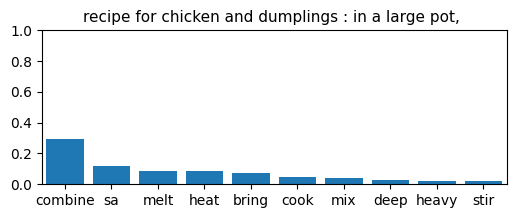

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

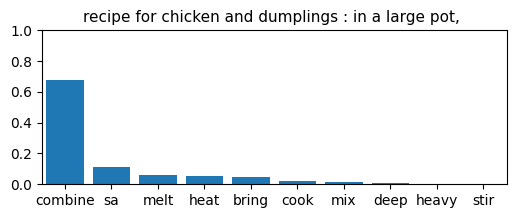

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

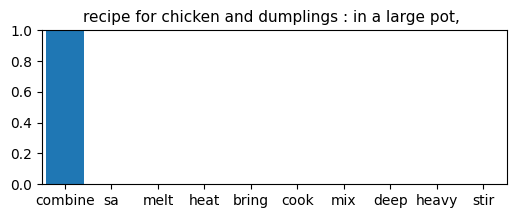

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

In [17]:
prompts = [
    'recipe for chicken steak : in a large bowl, combine the chicken, onion,',
    'recipe for chicken breasts : mix the garlic powder in a small bowl.',
    'in a small bowl. stir vegetable soup and mix in chicken',
]

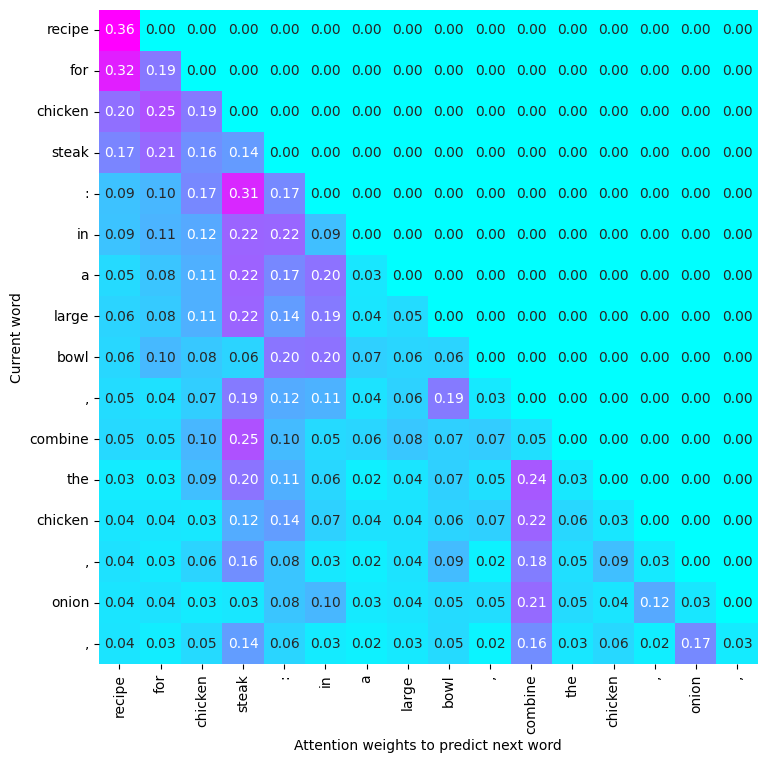

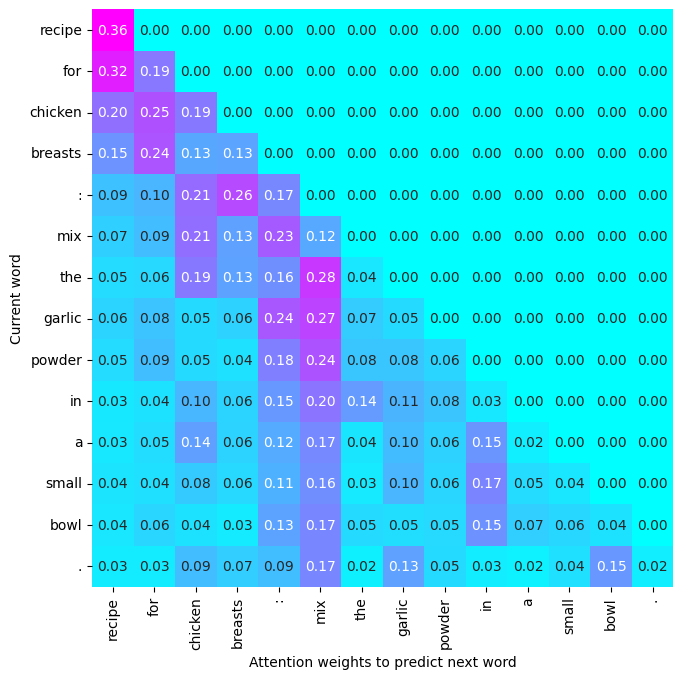

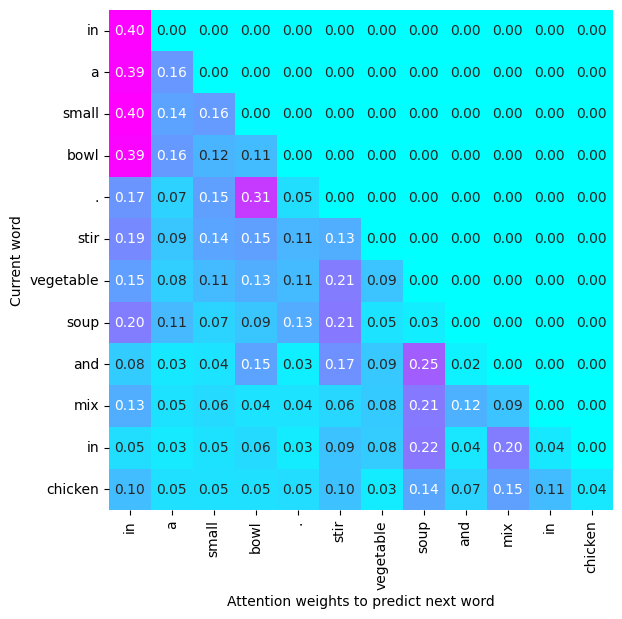

In [18]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(np.mean(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[1:text_len], yticklabels=labels[1:text_len],
                    cmap='cool', cbar=False, annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Attention weights to predict next word', ylabel='Current word')